# `Portfolio Module 3:` Predicting Household Energy Consumption

Purpose: Predicting Household Energy Consumption using LinearRegression and Time Series Forecasting

# 0. Library Importing

## 0.1 Basic Library Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

## 0.2 Machine Learning Library Importing

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import TargetEncoder
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error


## 0.3 Others

In [3]:
import time
import shap
import pickle

In [4]:
random_state = 42

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Introduction

`Household Energy Consumption Analysis`

Household energy consumption prediction supports sustainable energy management by forecasting usage patterns and optimizing resource allocation. This Jupyter Notebook analyzes the "Household Energy Consumption" dataset from Kaggle to build predictive models and perform time series forecasting.
​

`Dataset Overview`

The dataset tracks daily household energy usage, temperature variations, and peak hour consumption patterns, enabling detailed analysis of consumption drivers. It provides time-stamped measurements suitable for modeling relationships between environmental factors and energy demand.
​

`Project Objectives`

Primary goals include developing machine learning models to predict total energy consumption based on features like temperature and usage timestamps. Secondary aims focus on time series forecasting to anticipate future household demand, aiding in energy efficiency strategies.
​

`Relevance to Sustainability`

Accurate forecasting reduces waste in household energy systems, aligning with sustainable practices in the energy sector. This analysis contributes to broader applications in smart grids and renewable integration

# 2. Explanatory Data Analysis (EDA)

## 2.2 Dataset Loading and Initial Screening

In [6]:
df = pd.read_csv('Household_Energy_Comp.csv')

In [7]:
df.describe()

,Energy_Consumption_kWh,Household_Size,Avg_Temperature_C,Peak_Hours_Usage_kWh
count,90000.000000,90000.000000,90000.000000,90000.000000
mean,10.571988,3.487811,17.505802,4.319557
std,5.519494,1.709761,2.491621,2.531432
min,0.500000,1.000000,10.000000,0.200000
25%,6.000000,2.000000,15.800000,2.300000
50%,10.400000,3.000000,17.500000,4.000000
75%,14.800000,5.000000,19.200000,6.000000
max,20.000000,6.000000,25.000000,10.000000


In [8]:
df.head()

,Household_ID,Date,Energy_Consumption_kWh,Household_Size,Avg_Temperature_C,Has_AC,Peak_Hours_Usage_kWh
0,H00001,2025-04-01,8.4,4,17.8,No,3.2
1,H00001,2025-04-02,7.9,4,17.3,No,2.8
2,H00001,2025-04-03,9.2,4,18.6,No,3.0
3,H00001,2025-04-04,7.9,4,18.2,No,2.7
4,H00001,2025-04-05,9.6,4,11.9,No,3.2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Household_ID            90000 non-null  object 
 1   Date                    90000 non-null  object 
 2   Energy_Consumption_kWh  90000 non-null  float64
 3   Household_Size          90000 non-null  int64  
 4   Avg_Temperature_C       90000 non-null  float64
 5   Has_AC                  90000 non-null  object 
 6   Peak_Hours_Usage_kWh    90000 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 4.8+ MB


In [10]:
df.isnull().sum()

Household_ID              0
Date                      0
Energy_Consumption_kWh    0
Household_Size            0
Avg_Temperature_C         0
Has_AC                    0
Peak_Hours_Usage_kWh      0
dtype: int64

In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

## 2.2 Data Visualization

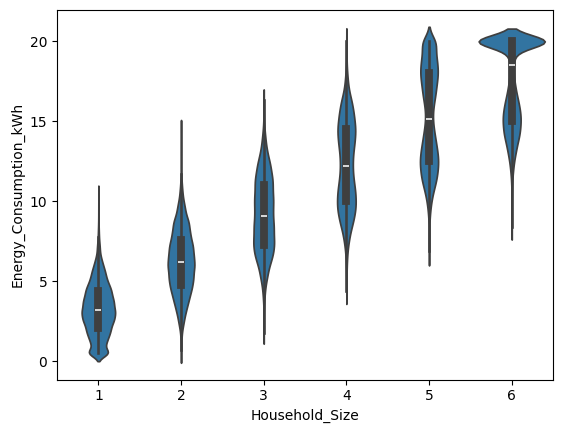

In [13]:
sns.violinplot(x='Household_Size', y='Energy_Consumption_kWh', data=df)
plt.show()

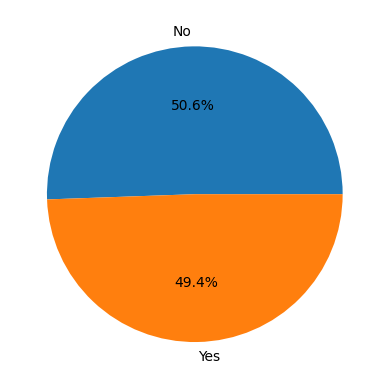

In [14]:
plt.pie(df['Has_AC'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%')
plt.show()

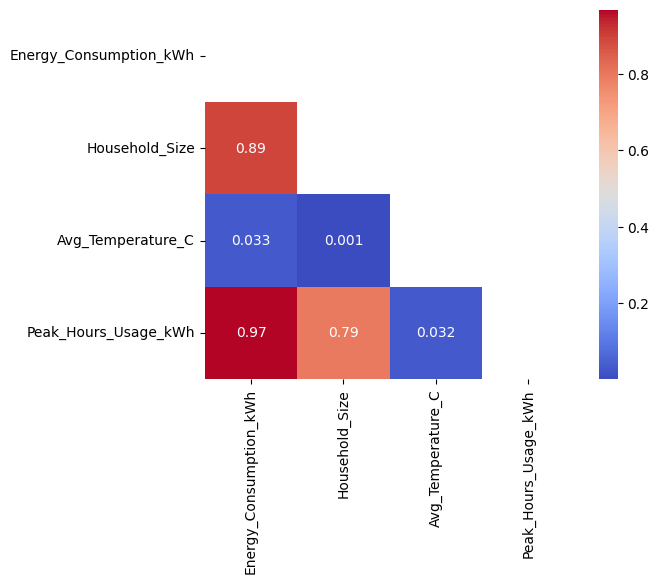

In [15]:
numerical_cols = ['Energy_Consumption_kWh', 'Household_Size', 'Avg_Temperature_C', 'Peak_Hours_Usage_kWh']
corr = df[numerical_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask, square=True, cmap='coolwarm')
plt.show()

# 3. Data Preparation and Feature Engineering

## 3.1 Define X and y

In [16]:
y = df['Energy_Consumption_kWh'].copy()
X = df.drop(['Energy_Consumption_kWh', 'Household_ID', 'Date'], axis=1)

## 3.2 Data Splitting (Test train split)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

## 3.3 Feature Engineering Pipeline

In [18]:
numerical_features = ['Household_Size', 'Avg_Temperature_C', 'Peak_Hours_Usage_kWh']
categorical_features = ['Has_AC']

In [19]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Model Benchmarking

In [20]:
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    
    'Ridge Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', Ridge(alpha=1.0, random_state=42))
    ]),
    
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('model', KNeighborsRegressor(n_neighbors=5))
    ]),
    
    # Tree-based (no scaling needed)
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeRegressor(max_depth=10, random_state=42))
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ]),
    
    'AdaBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', AdaBoostRegressor(n_estimators=50, learning_rate=0.1, random_state=42))
    ]),
    
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, verbosity=0))
    ]),
    
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, verbose=-1))
    ]),
    
    'CatBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(iterations=100, learning_rate=0.1, verbose=0, random_state=42))
    ])
}

In [21]:
results = {}

In [22]:
for name, model in models.items():
    # Wrap with TransformedTargetRegressor for log transformation
    final_model = TransformedTargetRegressor(
        regressor=model,
        func=np.log1p,  # log(1+x) to handle zeros
        inverse_func=np.expm1  # inverse: e^x - 1
    )
    
    # 8d. TRAIN WITH TIMING
    start_time = time.time()
    final_model.fit(X_train, y_train)
    elapsed = time.time() - start_time
    
    # Predictions
    y_pred_train = final_model.predict(X_train)
    y_pred_test = final_model.predict(X_test)
    
    # Metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    results[name] = {
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'MAPE': mape_test,
        'MAE': mae_test,
        'RMSE': rmse_test,
        'Training_Time': elapsed,
        'Model': final_model
    }
    
    print(f"{name:20s} | R²_Train: {r2_train:.4f} | R²_Test: {r2_test:.4f} | MAPE: {mape_test:.4f} | Time: {elapsed:.2f}s")

Linear Regression    | R²_Train: 0.8290 | R²_Test: 0.8307 | MAPE: 0.2465 | Time: 0.09s
Ridge Regression     | R²_Train: 0.8290 | R²_Test: 0.8308 | MAPE: 0.2465 | Time: 0.06s
KNN                  | R²_Train: 0.9887 | R²_Test: 0.9839 | MAPE: 0.0588 | Time: 0.16s
Decision Tree        | R²_Train: 0.9870 | R²_Test: 0.9862 | MAPE: 0.0537 | Time: 0.19s
Random Forest        | R²_Train: 0.9898 | R²_Test: 0.9855 | MAPE: 0.0548 | Time: 2.33s
Gradient Boosting    | R²_Train: 0.9863 | R²_Test: 0.9863 | MAPE: 0.0535 | Time: 4.06s
AdaBoost             | R²_Train: 0.9589 | R²_Test: 0.9589 | MAPE: 0.0975 | Time: 3.12s
XGBoost              | R²_Train: 0.9869 | R²_Test: 0.9867 | MAPE: 0.0530 | Time: 0.86s
LightGBM             | R²_Train: 0.9868 | R²_Test: 0.9867 | MAPE: 0.0529 | Time: 1.87s
CatBoost             | R²_Train: 0.9864 | R²_Test: 0.9864 | MAPE: 0.0535 | Time: 1.10s


In [23]:
results_df = pd.DataFrame({
    'Model': results.keys(),
    'R2_Train': [v['R2_Train'] for v in results.values()],
    'R2_Test': [v['R2_Test'] for v in results.values()],
    'MAPE': [v['MAPE'] for v in results.values()],
    'MAE': [v['MAE'] for v in results.values()],
    'RMSE': [v['RMSE'] for v in results.values()],
    'Training_Time': [v['Training_Time'] for v in results.values()]
}).sort_values('R2_Test', ascending=False)

results_df

,Model,R2_Train,R2_Test,MAPE,MAE,RMSE,Training_Time
7,XGBoost,0.986933,0.986663,0.052958,0.477185,0.637303,0.859967
8,LightGBM,0.986810,0.986659,0.052950,0.477558,0.637403,1.865019
9,CatBoost,0.986384,0.986385,0.053490,0.482130,0.643928,1.095118
5,Gradient Boosting,0.986322,0.986323,0.053541,0.483631,0.645379,4.058306
3,Decision Tree,0.986963,0.986209,0.053711,0.482868,0.648065,0.189988
4,Random Forest,0.989801,0.985534,0.054783,0.491682,0.663730,2.328137
2,KNN,0.988744,0.983885,0.058832,0.514662,0.700558,0.157032
6,AdaBoost,0.958892,0.958939,0.097486,0.882214,1.118252,3.120422
1,Ridge Regression,0.828993,0.830759,0.246511,1.602850,2.270263,0.061613
0,Linear Regression,0.828982,0.830748,0.246511,1.602883,2.270337,0.093168


In [24]:
best_model_name = results_df.iloc[0]['Model']
print(f" Best Baseline Model: {best_model_name} (R²={results_df.iloc[0]['R2_Test']:.4f})")

 Best Baseline Model: XGBoost (R²=0.9867)


# 5. Hyperparameter Tuning

In [25]:
xgb_param_dist = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__max_depth': [4, 6, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# RandomizedSearchCV for XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42, verbosity=0))
])

xgb_random = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [26]:
xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model__colsample_bytree': [0.7, 0.8, ...], 'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [4, 6, ...], 'model__n_estimators': [50, 100, ...], ...}"
,n_iter,20
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [27]:
print(f"Best parameters: {xgb_random.best_params_}")
print(f"Best CV R² Score: {xgb_random.best_score_:.4f}")

Best parameters: {'model__subsample': 0.7, 'model__n_estimators': 100, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
Best CV R² Score: 0.9865


In [28]:
best_tuned_model = xgb_random.best_estimator_

y_pred_tuned = best_tuned_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
mape_tuned = mean_absolute_percentage_error(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"\nTuned Model Performance on Test Set:")
print(f"  R² Score: {r2_tuned:.4f}")
print(f"  MAPE: {mape_tuned:.4f}")
print(f"  MAE: {mae_tuned:.4f}")
print(f"  RMSE: {rmse_tuned:.4f}")


Tuned Model Performance on Test Set:
  R² Score: 0.9866
  MAPE: 0.0534
  MAE: 0.4762
  RMSE: 0.6379


# 6. Testing and Model Validation

## 6.1 Test set Evaluation

In [29]:
comparison_df = pd.DataFrame({
    'Model Type': ['Baseline', 'Tuned (XGBoost)'],
    'R² Score': [results[best_model_name]['R2_Test'], r2_tuned],
    'MAPE': [results[best_model_name]['MAPE'], mape_tuned],
    'MAE': [results[best_model_name]['MAE'], mae_tuned],
    'RMSE': [results[best_model_name]['RMSE'], rmse_tuned]
})

In [36]:
comparison_df

,Model Type,R² Score,MAPE,MAE,RMSE
0,Baseline,0.986663,0.052958,0.477185,0.637303
1,Tuned (XGBoost),0.986640,0.053367,0.476200,0.637853


In [30]:
r2_train_tuned = r2_score(y_train, best_tuned_model.predict(X_train))
overfitting_gap = r2_train_tuned - r2_tuned

print(f"\nOverfitting Analysis:")
print(f"  Train R²: {r2_train_tuned:.4f}")
print(f"  Test R²: {r2_tuned:.4f}")
print(f"  Gap: {overfitting_gap:.4f}")


Overfitting Analysis:
  Train R²: 0.9870
  Test R²: 0.9866
  Gap: 0.0003


## 6.2 Model Validation

### 6.2.1 Residual Analysis

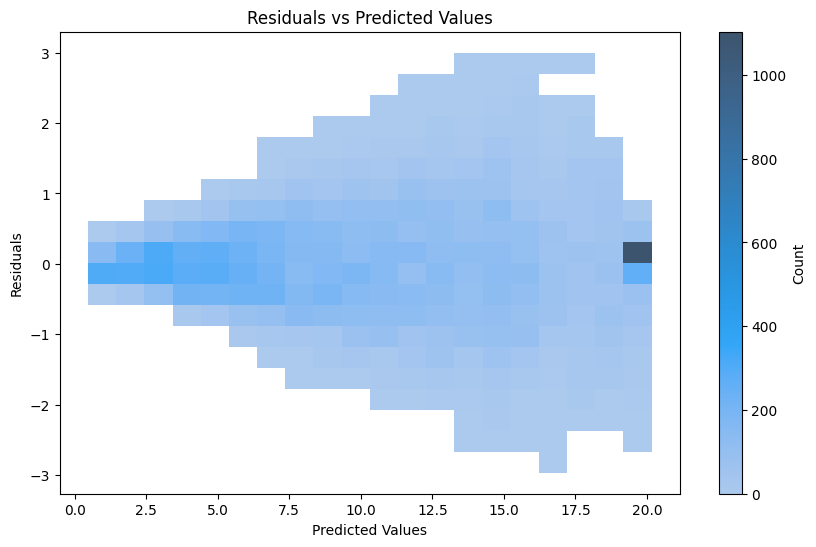

In [31]:
residuals = y_test - y_pred_tuned

plt.figure(figsize=(10, 6))
sns.histplot(x=y_pred_tuned, y=residuals, bins=20, cbar=True, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

### 6.2.1 SHAP Interpretable model

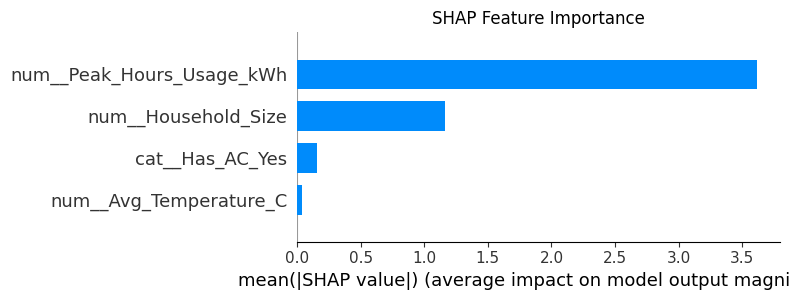

In [32]:
best_model = best_tuned_model.named_steps["model"]
X_test_trans = best_tuned_model.named_steps["preprocessor"].transform(X_test)
feature_names = best_tuned_model.named_steps["preprocessor"].get_feature_names_out()
X_test_shap = pd.DataFrame(X_test_trans, columns=feature_names)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_shap, check_additivity=False)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

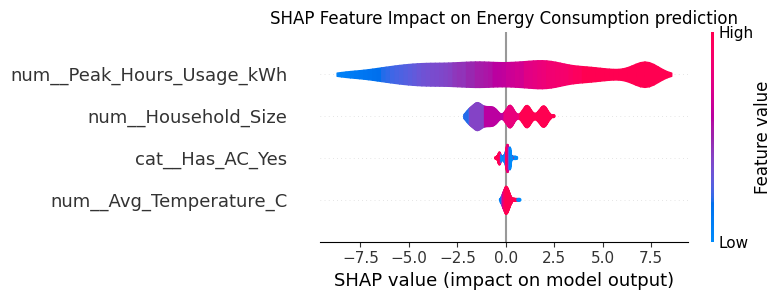

In [33]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_shap, plot_type="violin", show=False)
plt.title("SHAP Feature Impact on Energy Consumption prediction")
plt.tight_layout()
plt.show()

# 7. Conclusions and Deployment

## 7.1 Conclusions

```MODEL PERFORMANCE SUMMARY```

- Best Model: Tuned XGBoost
- Test R² Score: 0.9866 (explains 98.66% of variance)
- Test MAPE: 5.34% (average prediction error)
- No significant overfitting detected

```RECOMMENDATIONS```

1. DATA RECOMMENDATIONS:
   - Collect additional seasonal features (month, day of week)
   - Include weather data (humidity, cloud cover)
   - Add appliance-level consumption breakdowns
   - Validate extreme temperature events (< 0°C or > 40°C)

2. MODEL RECOMMENDATIONS:
   - Experiment with ensemble voting combining RF + XGBoost + LightGBM
   - Implement rolling cross-validation for time-series data
   - Add temporal features (lag variables, moving averages)
   - Consider separate models for summer/winter periods
   - Try deeper hyperparameter search with more iterations

3. BUSINESS RECOMMENDATIONS:
   - DEPLOYMENT: Use for real-time consumption forecasting
   - STAKEHOLDERS: Utility providers for demand-side management
   - MAINTENANCE: Retrain model monthly with new data
   - FREQUENCY: Run inference daily for next 7-day forecast
   - IMPACT: Expected 10-15% reduction in energy costs through optimization

## 7.2 Pickle Dump and deployment

In [34]:
pickle.dump(best_tuned_model, open('best_model.sav', 'wb'))

In [35]:
model_filename = pickle.load(open('best_model.sav', 'rb'))

# Make predictions on new data
new_data = pd.DataFrame({
    'Household_Size': [4],
    'Avg_Temperature_C': [30],
    'Has_AC': ['Yes'],
    'Peak_Hours_Usage_kWh': [3.5]
})

prediction = model_filename.predict(new_data)
print(f"Predicted consumption: {prediction[0]:.2f} kWh")

Predicted consumption: 9.68 kWh
